In [1]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import random

import numpy as np

import matplotlib.cm as cm

import pickle

from denoising_assessment_project.utils import functions

%matplotlib notebook

import os

In [4]:
# restoring variables from memory 
%store -r

In [5]:
def identify_BETTER_and_WORSE_alternative(noise_metrics_stats_data, metric_stats_data, metric): 
    values = metric_stats_data[:,:,0]
    std = metric_stats_data[:,:,1]
    noise_values = noise_metrics_stats_data[:,:,0]
    noise_std = noise_metrics_stats_data[:,:,1]
    if metric=='NRMSE' or metric=='RMSE':
        values_BETTER = torch.where(values < noise_values, values, 0)
        std_BETTER = torch.where(values < noise_values, std, 0)
        
        values_WORSE = torch.where(values >= noise_values, values, 0)
        std_WORSE = torch.where(values >= noise_values, std, 0)
    elif metric=='PSNR' or metric=='MS_SSIM' or metric=='SSIM': 
        values_BETTER = torch.where(values > noise_values, values, 0)
        std_BETTER = torch.where(values > noise_values, std, 0)
        
        values_WORSE = torch.where(values <= noise_values, values, 0)
        std_WORSE = torch.where(values <= noise_values, std, 0)
    else: 
        raise Exception("Unsupported metric")
    return [values_BETTER, std_BETTER, values_WORSE, std_WORSE]

In [29]:
metric_stats_CARE_list = [metric_stats_NRMSE_CARE, metric_stats_RMSE_CARE, metric_stats_PSNR_CARE, metric_stats_SSIM_CARE, metric_stats_MS_SSIM_CARE]
metric_stats_NOISE_list = [metric_stats_NRMSE, metric_stats_RMSE, metric_stats_PSNR, metric_stats_SSIM, metric_stats_MS_SSIM]
metrics_list = ['NRMSE', 'RMSE', 'PSNR', 'SSIM', 'MS_SSIM']

map_tensor = torch.zeros(metric_stats_NOISE_list[0][:,:,0].shape)

assert len(metric_stats_CARE_list) == len(metric_stats_NOISE_list) 
assert len(metric_stats_CARE_list) == len(metrics_list)

for idx in range(len(metric_stats_CARE_list)): 
    output_idx = identify_BETTER_and_WORSE_alternative(metric_stats_NOISE_list[idx], metric_stats_CARE_list[idx], metrics_list[idx])[0]
    map_tensor = torch.where(output_idx != 0, map_tensor+1, map_tensor)

In [28]:
# alternative view version - each metric separately 
# 5 separate tensor maps 
map_tensor = torch.zeros(metric_stats_NOISE_list[0][:,:,0].shape)
map_tensor_5 = map_tensor.repeat(5,1,1)

assert len(metric_stats_CARE_list) == len(metric_stats_NOISE_list) 
assert len(metric_stats_CARE_list) == len(metrics_list)

for idx in range(len(metric_stats_CARE_list)): 
    output_idx = identify_BETTER_and_WORSE_alternative(metric_stats_NOISE_list[idx], metric_stats_CARE_list[idx], metrics_list[idx])[0]
    map_tensor_5[idx,:,:] = torch.where(output_idx != 0, map_tensor_5[idx,:,:]+1, map_tensor_5[idx,:,:])

torch.Size([5, 20, 20])


In [15]:
# opening GT images 
with open('pickled_data/EVAL/un_noised_images_eval_27_06.pkl', 'rb') as un_noised_images_eval_27_06_pickled:
    un_noised_images = pickle.load(un_noised_images_eval_27_06_pickled)

<IPython.core.display.Javascript object>


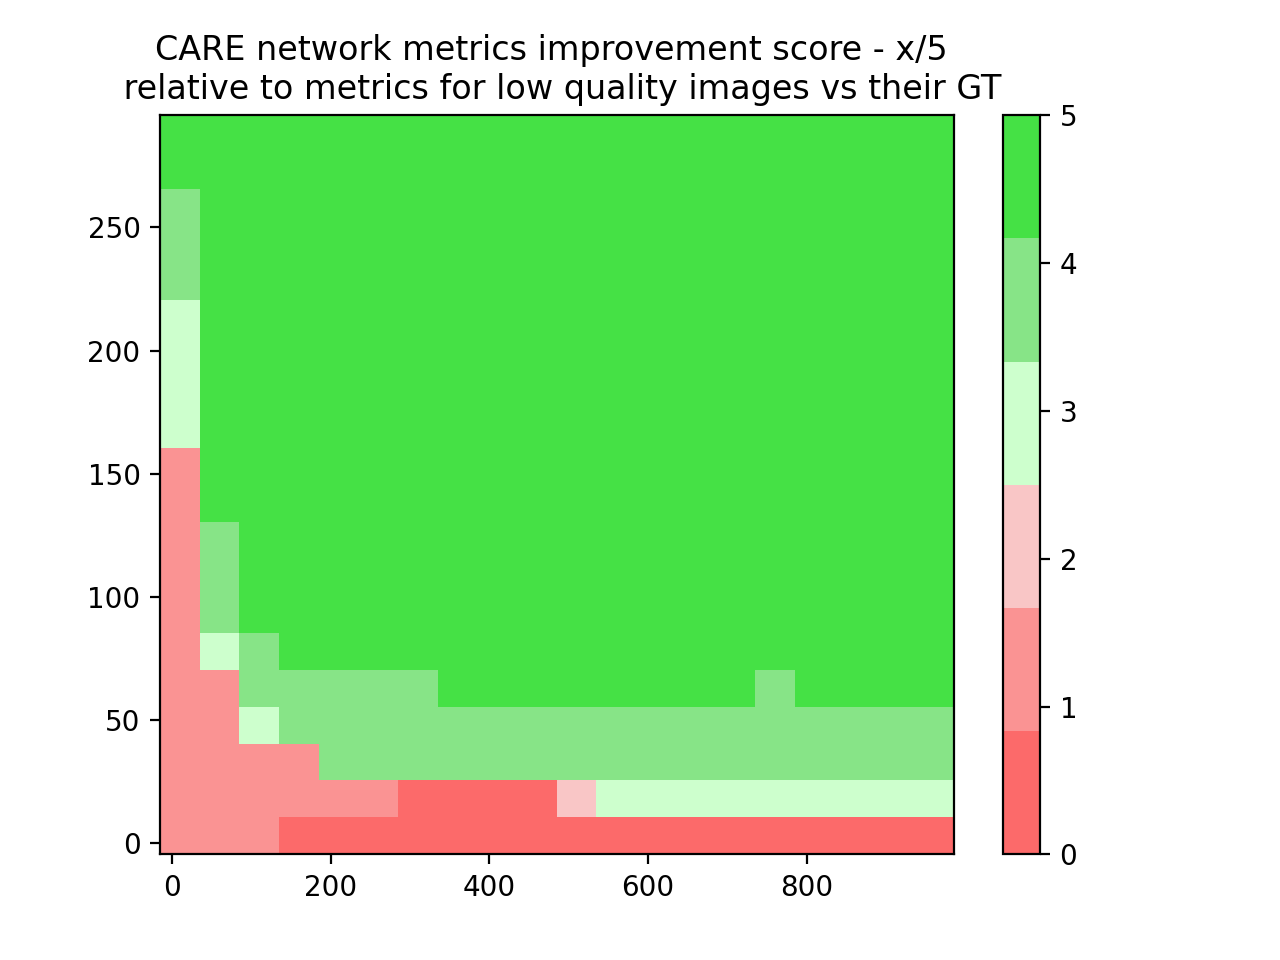

In [31]:
from matplotlib import colors
# source: https://stackoverflow.com/questions/43971138/python-plotting-colored-grid-based-on-values
# create discrete colormap
cmap = colors.ListedColormap(['#FC6A6A', '#FA9393', '#F9C6C6', '#CDFFCD', '#87E487', '#45E145'])
bounds = [0,1,2,3,4,5,6]
norm = colors.BoundaryNorm(bounds, cmap.N)

y, x = np.meshgrid(ticks_X, ticks_Y)

z = map_tensor.numpy()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap=cmap)
ax.set_title('CARE network metrics improvement score - x/5 \n relative to metrics for low quality images vs their GT')

fig.colorbar(c, ax=ax)

plt.show()

<IPython.core.display.Javascript object>


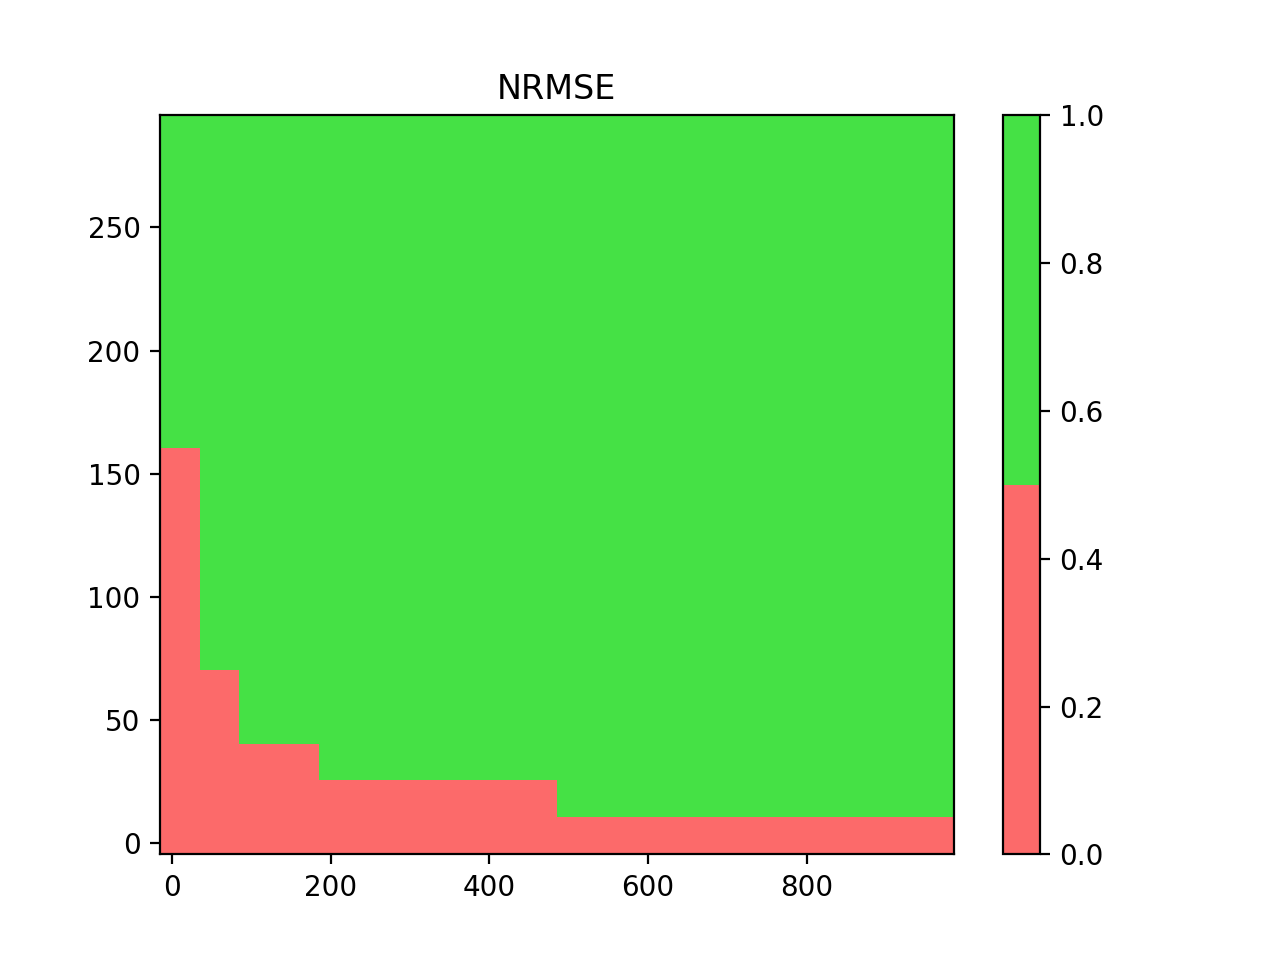

<IPython.core.display.Javascript object>


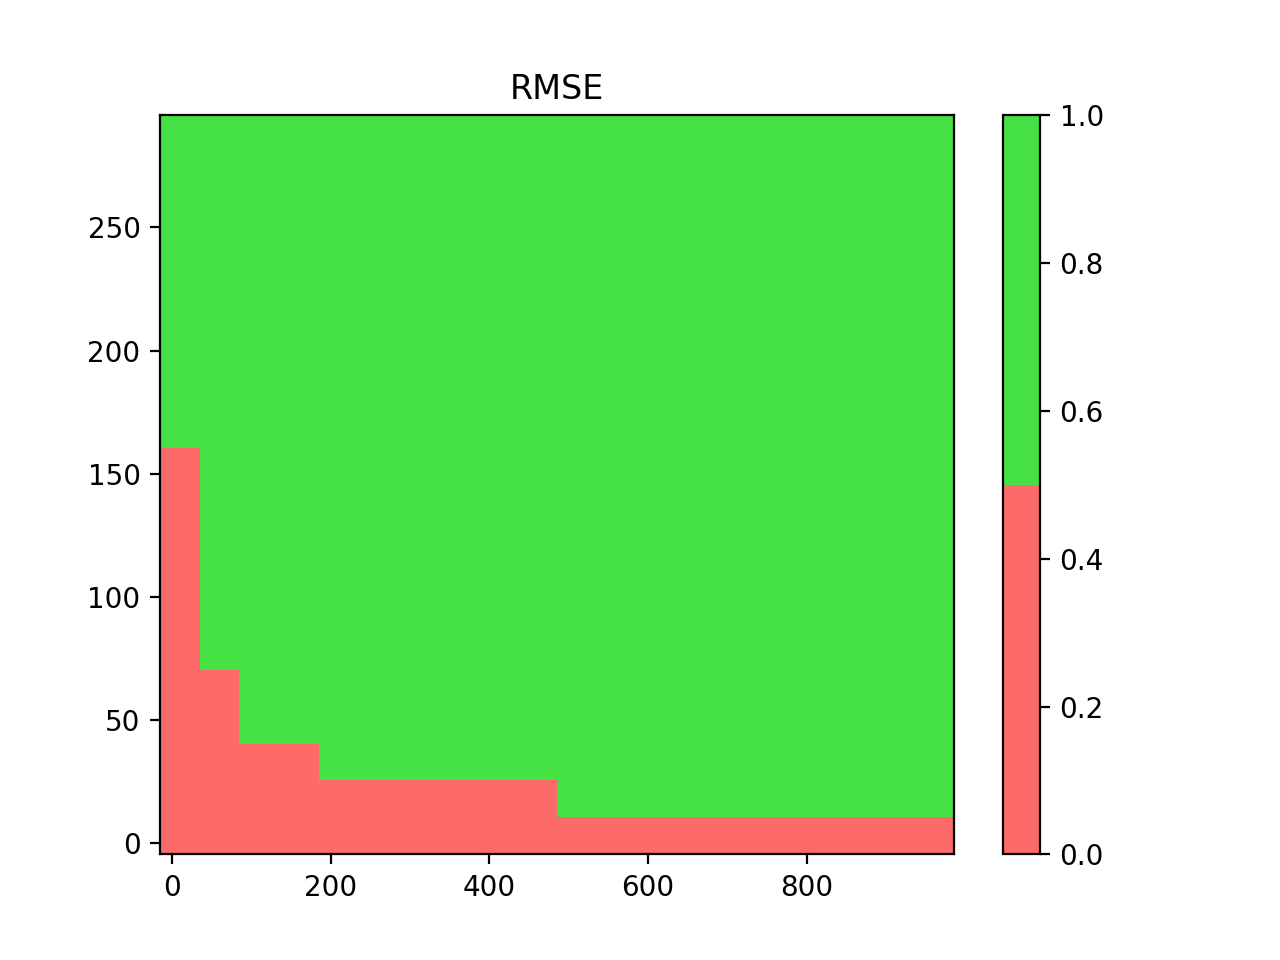

<IPython.core.display.Javascript object>


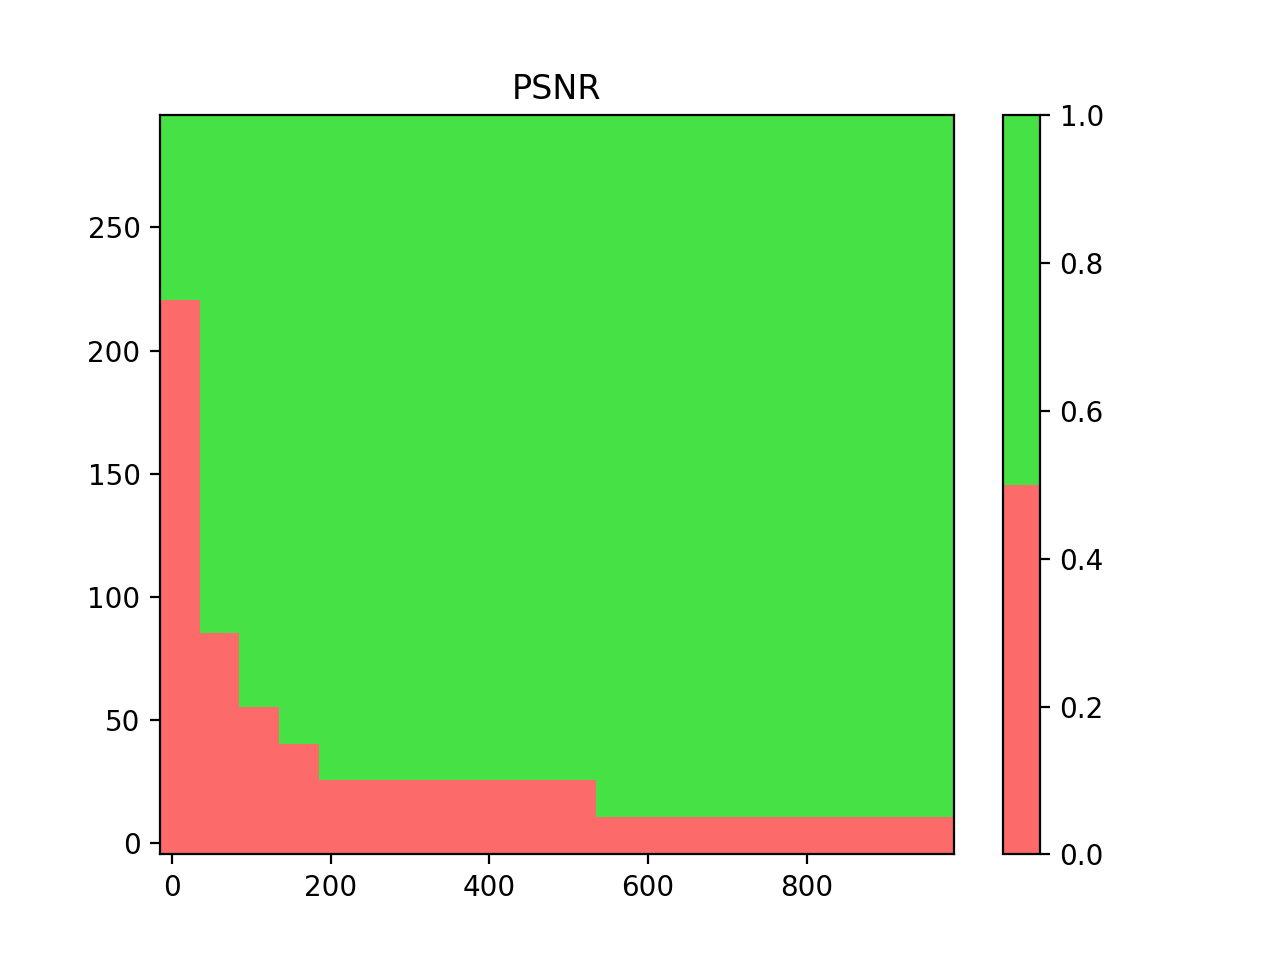

<IPython.core.display.Javascript object>


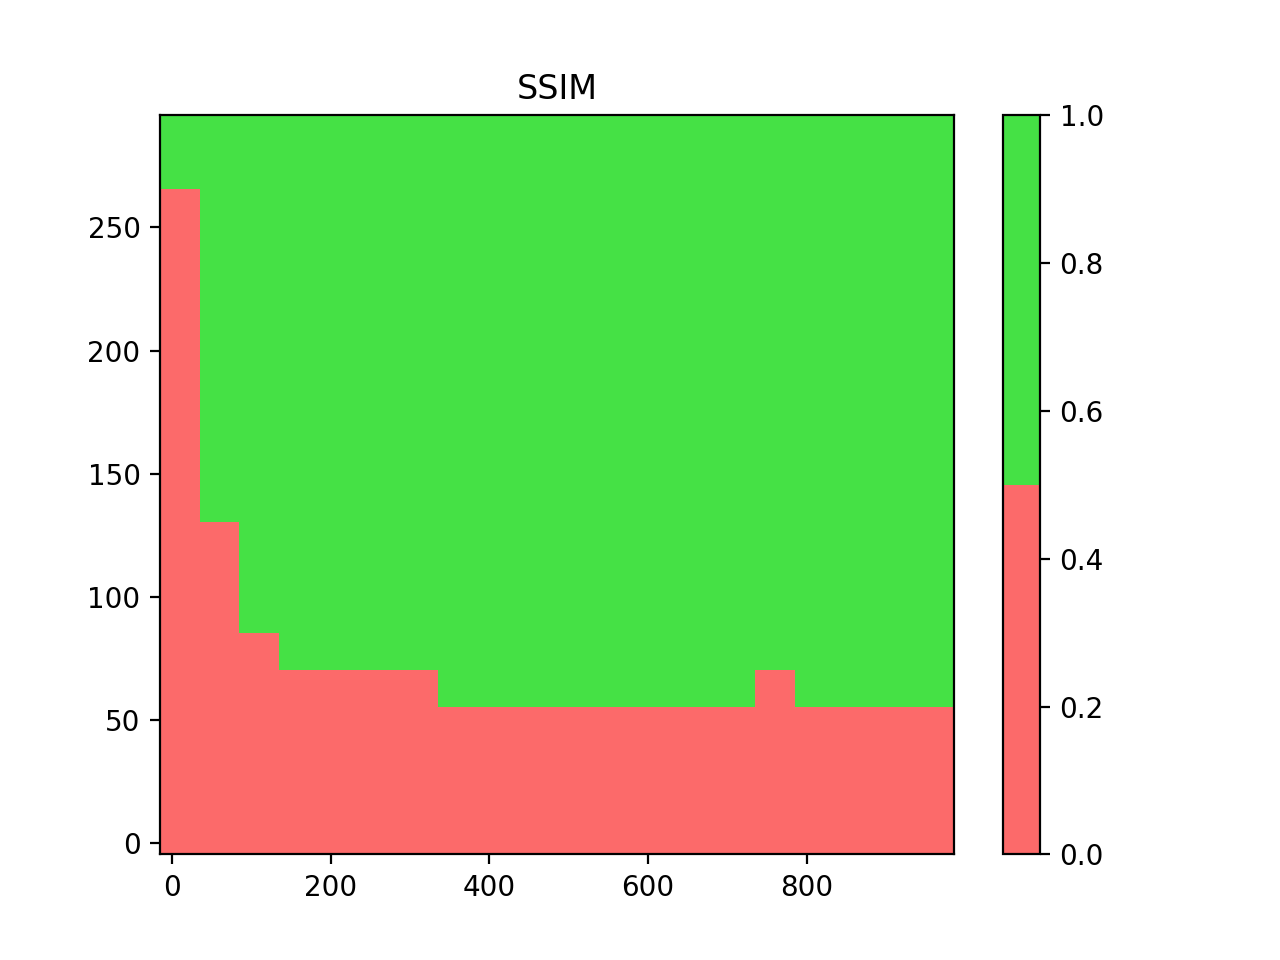

<IPython.core.display.Javascript object>


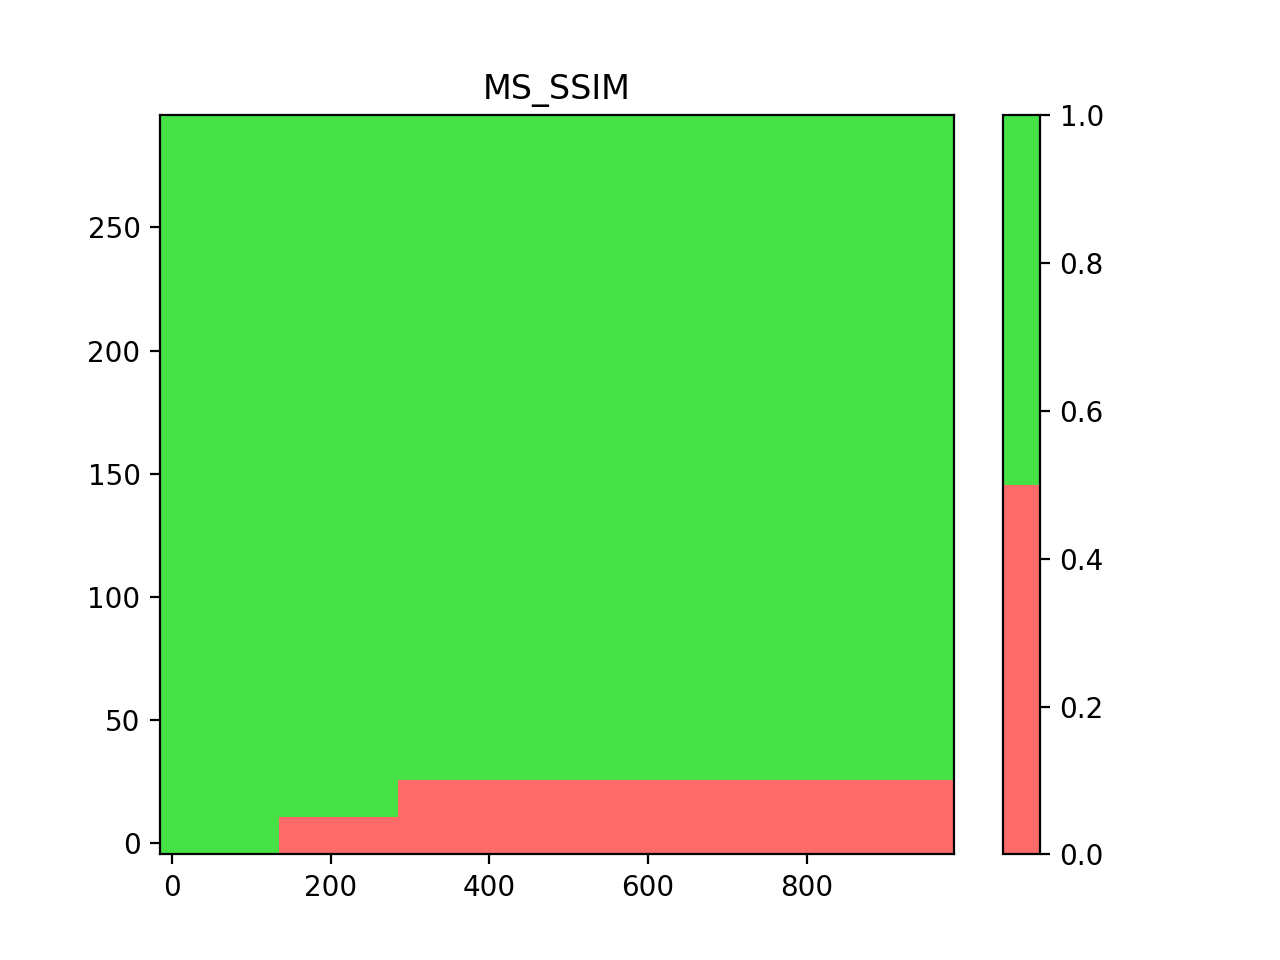

In [34]:
# 5 separate plots based on the map_tensor_5 data 
# source: https://stackoverflow.com/questions/43971138/python-plotting-colored-grid-based-on-values
# create discrete colormap
cmap = colors.ListedColormap(['#FC6A6A', '#45E145'])
bounds = [0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)

y, x = np.meshgrid(ticks_X, ticks_Y)

for idx in range(map_tensor_5.shape[0]):
    z = map_tensor_5[idx].numpy()
    fig, ax = plt.subplots()
    c = ax.pcolormesh(x, y, z, cmap=cmap)
    ax.set_title(metrics_list[idx])

    fig.colorbar(c, ax=ax)

plt.show()